In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import math
import joblib

from catboost import CatBoostRegressor

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df

,Id,Timestep,Course,Faculty,Expected
0,0,AY1810-AY1811,VX27870,Prof. Jadon Haney,386
1,1,AY1810-AY1811,SN11041,Prof. Kennedy Shields,158
2,2,AY1810-AY1811,CG17623,Prof. Brandon Silva,303
3,3,AY1810-AY1811,GW27856,Prof. Lorena Mays,207
4,4,AY1810-AY1811,SI10212,Prof. Haleigh Romero,329
...,...,...,...,...,...
89995,89995,AY1986-AY1987,BE26459,Prof. John Perkins,476
89996,89996,AY1986-AY1987,VZ14984,Prof. Kale Haynes,222
89997,89997,AY1986-AY1987,XP22492,Prof. Tommy Hogan,295
89998,89998,AY1986-AY1987,YN11430,Prof. Christopher Dennis,187


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        90000 non-null  int64 
 1   Timestep  90000 non-null  object
 2   Course    90000 non-null  object
 3   Faculty   90000 non-null  object
 4   Expected  90000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.4+ MB


In [6]:
df['Course'].value_counts()

GK29879    157
IX29155    151
ZW13749    151
LY11566    151
AO12551    151
          ... 
TV18763    124
BW24288    123
OL24651    123
SA20222    121
PA22070    121
Name: Course, Length: 656, dtype: int64

In [7]:
df['Faculty'].value_counts()

Prof. Leonard House         263
Prof. Gage Davies           261
Prof. Elyse Hood            261
Prof. Ali Weaver            258
Prof. Marcelo Rasmussen     258
                           ... 
Prof. Cherish Barrera       124
Prof. Sarah Kane            124
Prof. Keaton Hines          123
Prof. Dexter Bolton         123
Prof. Houston Williamson    122
Name: Faculty, Length: 560, dtype: int64

In [8]:
df['Year'] = df['Timestep'].apply(lambda x: int(x[2:6]))

In [9]:
up_margine = df['Expected'].mean() + 3*df['Expected'].std()
up_margine

1275.369564009362

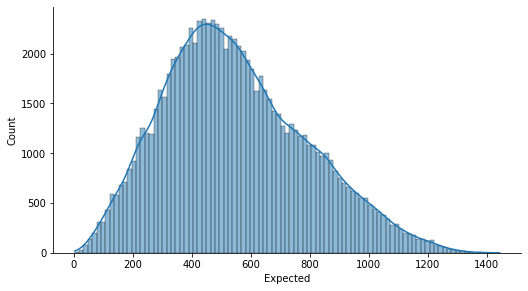

In [10]:
sns.displot(df['Expected'], kde = True)
plt.gcf().set_size_inches(8,4)

In [10]:
# df = df[df['Expected'] < up_margine]

In [11]:
Course_dummies = pd.get_dummies(df['Course'])
Course_dummies

,AB18023,AB20928,AB25695,AD18559,AD21894,AJ19783,AL19784,AL28154,AM18690,AN11745,...,ZS11345,ZS16168,ZS29879,ZU20965,ZU29326,ZV18131,ZV23833,ZW13749,ZX11344,ZZ23306
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df = pd.concat([df, Course_dummies.drop('ZZ23306', axis = 'columns')], axis='columns')
df

,Id,Timestep,Course,Faculty,Expected,Year,AB18023,AB20928,AB25695,AD18559,...,ZR13208,ZS11345,ZS16168,ZS29879,ZU20965,ZU29326,ZV18131,ZV23833,ZW13749,ZX11344
0,0,AY1810-AY1811,VX27870,Prof. Jadon Haney,386,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,AY1810-AY1811,SN11041,Prof. Kennedy Shields,158,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,AY1810-AY1811,CG17623,Prof. Brandon Silva,303,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,AY1810-AY1811,GW27856,Prof. Lorena Mays,207,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,AY1810-AY1811,SI10212,Prof. Haleigh Romero,329,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,89995,AY1986-AY1987,BE26459,Prof. John Perkins,476,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89996,89996,AY1986-AY1987,VZ14984,Prof. Kale Haynes,222,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89997,89997,AY1986-AY1987,XP22492,Prof. Tommy Hogan,295,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89998,89998,AY1986-AY1987,YN11430,Prof. Christopher Dennis,187,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
Faculty_dummies = pd.get_dummies(df['Faculty'])
Faculty_dummies

,Prof. Aaliyah Cline,Prof. Adelaide Holt,Prof. Adelyn Velasquez,Prof. Aden Mcgrath,Prof. Adison Lucas,Prof. Adrian Mathews,Prof. Adriana Anthony,Prof. Adrianna Frank,Prof. Adyson Guerrero,Prof. Aedan King,...,Prof. Warren Wall,Prof. Willow Moon,Prof. Wilson Hutchinson,Prof. Yael Powell,Prof. Yosef Becker,Prof. Yurem Horton,Prof. Zain Cox,Prof. Zara Le,Prof. Zion Mcgee,Prof. Zoie Mueller
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df = pd.concat([df, Faculty_dummies.drop('Prof. Zoie Mueller', axis = 'columns')], axis='columns')
df

,Id,Timestep,Course,Faculty,Expected,Year,AB18023,AB20928,AB25695,AD18559,...,Prof. Wade Taylor,Prof. Warren Wall,Prof. Willow Moon,Prof. Wilson Hutchinson,Prof. Yael Powell,Prof. Yosef Becker,Prof. Yurem Horton,Prof. Zain Cox,Prof. Zara Le,Prof. Zion Mcgee
0,0,AY1810-AY1811,VX27870,Prof. Jadon Haney,386,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,AY1810-AY1811,SN11041,Prof. Kennedy Shields,158,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,AY1810-AY1811,CG17623,Prof. Brandon Silva,303,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,AY1810-AY1811,GW27856,Prof. Lorena Mays,207,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,AY1810-AY1811,SI10212,Prof. Haleigh Romero,329,1810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,89995,AY1986-AY1987,BE26459,Prof. John Perkins,476,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89996,89996,AY1986-AY1987,VZ14984,Prof. Kale Haynes,222,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89997,89997,AY1986-AY1987,XP22492,Prof. Tommy Hogan,295,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89998,89998,AY1986-AY1987,YN11430,Prof. Christopher Dennis,187,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


KeyboardInterrupt: 

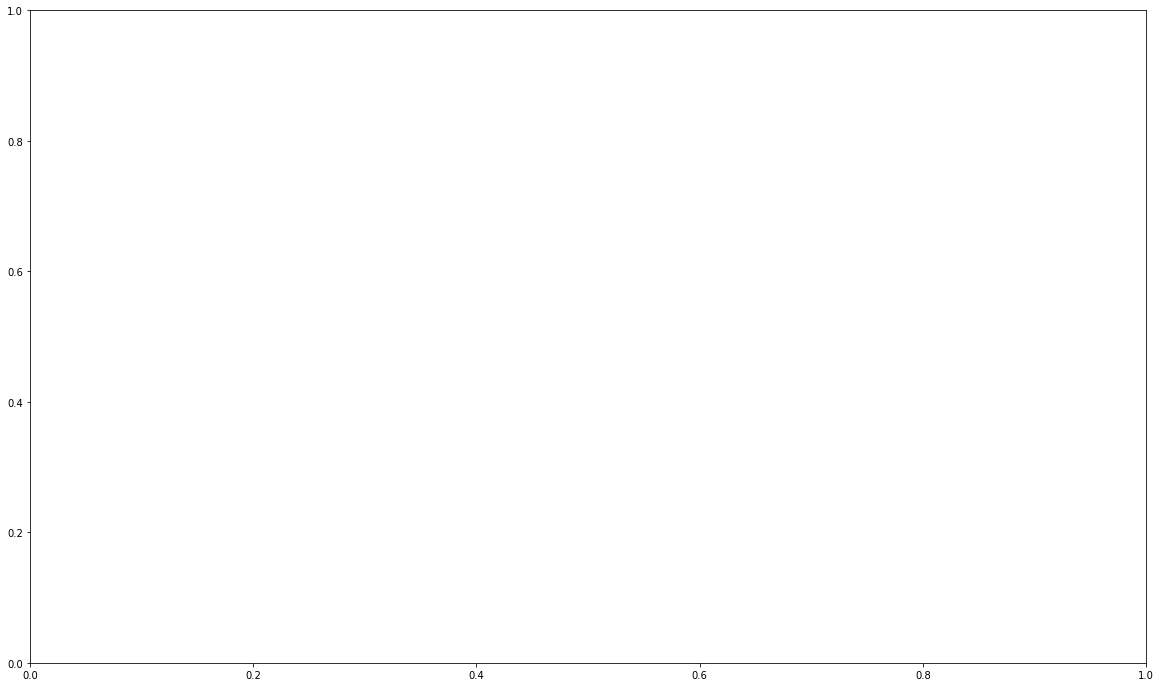

In [15]:
plt.figure(figsize = (20, 12))
plt.bar(df['Year'], df['Expected'])

In [16]:
min_year = 0
max_year = 3000

df['Year_'] = df['Year'].apply(lambda x: ( x - min_year ) / ( max_year - min_year ))

In [17]:
min_Expected = 0
max_Expected = 3000

df['Expected_'] = df['Expected'].apply(lambda x: ( x - min_Expected ) / ( max_Expected - min_Expected ))

In [18]:
df.dtypes

Id                    int64
Timestep             object
Course               object
Faculty              object
Expected              int64
                     ...   
Prof. Zain Cox        uint8
Prof. Zara Le         uint8
Prof. Zion Mcgee      uint8
Year_               float64
Expected_           float64
Length: 1222, dtype: object

In [19]:
x = df.drop(['Id', 'Timestep', 'Course', 'Faculty', 'Expected', 'Year_', 'Expected_'], axis = 'columns')

In [20]:
y = df['Expected']

In [21]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [22]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

d = len(df)

x_train = x[:int(d*0.8)]
y_train = y[:int(d*0.8)]

x_test = x[int(d*0.8):]
y_test = y[int(d*0.8):]

In [23]:
model = CatBoostRegressor(
#                             iterations=1000,
                            learning_rate=0.75,
                            depth = 8,
                            n_estimators = 2000
)

In [25]:
model.fit(x_train, y_train,
          verbose = False,
          plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [32]:
# y_pred = pd.DataFrame(model.predict(x_test))

y_pred = model.predict(x_test)

In [24]:
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i] + 25

NameError: name 'y_pred' is not defined

In [34]:
np.sqrt(mean_squared_error(y_test, y_pred))

34.290419883372934

In [26]:
model.fit(x, y, 
          verbose = False,
          plot = True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [38]:
joblib.dump(model, "model_late.joblib")

['model_cat_34.joblib']

In [25]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(x_train))

In [26]:
# def build_and_compile_model():
#     model = keras.Sequential([
#         norm,
#         layers.Dense(32, activation='linear'),
#         layers.Dense(32, activation='sigmoid'),
#         layers.Dense(32, activation='linear'),
#         layers.Dense(1, activation="linear")
#   ])

#     model.compile(loss='mean_squared_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#     return model

In [27]:
# model = build_and_compile_model()
# model.summary()

In [28]:
# %%time
# history = model.fit(
#     x_train,
#     y_train,
#     validation_split=0.2,
#     verbose=True, 
#     epochs=1)

In [29]:
# hidden_units1 = 256
# hidden_units2 = 480
# hidden_units3 = 160
# learning_rate = 0.01

# # Creating model using the Sequential in tensorflow
# def build_model_using_sequential(norm):
#     model = Sequential([
#         norm,
#         Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
#         Dropout(0.2),
#         Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
#         Dropout(0.2),
#         Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
#         Dense(1, kernel_initializer='normal', activation='linear')
#     ])
#     return model

# # build the model
# model = build_model_using_sequential(normalizer)
# model.summary()

In [30]:
# # loss function
# mse = tf.keras.losses.MeanSquaredError()
# model.compile(
#     loss=mse, 
#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate), 
#     metrics=[mse]
# )
# # train the model
# history = model.fit(
#     x_train.values, 
#     y_train.values, 
#     epochs=1, 
#     batch_size=1,
#     validation_split=0.2
# )

In [31]:
# plt.plot(history.history['loss'], color = 'blue', label = 'loss')
# plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')

# plt.legend()

In [35]:
# np.sqrt(mean_squared_error(y_test, y_pred))*3000

In [36]:
# mean_squared_error(y_test, y_pred)

In [39]:
# feature_list = x.columns

In [40]:
# # Get numerical feature importances
# importances = list(model.feature_importances_)
# # List of tuples with variable and importance
# feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# # Sort the feature importances by most important first
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# # Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

In [41]:
# x.drop([pair[0] for pair in feature_importances if pair[1] == 0], axis = 'columns', inplace = True)

In [42]:
# d = len(df)

# x_train = x[:int(d*0.8)]
# y_train = y[:int(d*0.8)]

# x_test = x[int(d*0.8):]
# y_test = y[int(d*0.8):]

In [43]:
# model = CatBoostRegressor(
# #                             iterations=1000,
#                             learning_rate=0.75,
#                             depth = 9,
#                             n_estimators = 2000
# )

In [44]:
# model.fit(x_train, y_train,
#           verbose = False,
#           plot = True)

In [45]:
# y_pred = pd.DataFrame(model.predict(x_test))

In [46]:
# np.sqrt(mean_squared_error(y_test, y_pred))

In [47]:
# np.sqrt(mean_squared_error(y_test, y_pred))*3000

In [48]:
# mean_squared_error(y_test, y_pred)

In [49]:
# joblib.dump(model, "/content/drive/MyDrive/B.Tech/Hackrush'22 ML Challenge/model_Linear_3.joblib")

In [50]:
# from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestRegressor

In [51]:
# model = LogisticRegression()
# model = SVC(kernel='rbf', random_state = 1)
# model = LinearRegression()
# model = Lasso(alpha = 1, tol = 0.01)
# model = RandomForestRegressor(n_estimators = 10)

In [52]:
# scores = cross_val_score(model, x[80000:], y[80000:], cv=5)
# scores

In [53]:
# model.fit(x_train, y_train)

In [54]:
# y_pred = model.predict(x_test)

In [55]:
# mean_squared_error(y_test, y_pred)

In [56]:
# sns.displot(df['Expected'], kde = True)
# plt.gcf().set_size_inches(8,4)

In [57]:
# min_threshold, max_threshold = df['Expected'].quantile([0.01,0.99])
# min_threshold, max_threshold

In [58]:
# y.describe()

In [59]:
# df1 = df[(df["Expected"] > min_threshold) & (df["Expected"] < max_threshold)]

In [60]:
# sns.displot(df1['Expected'], kde = True)
# plt.gcf().set_size_inches(8,4)

In [61]:
# x = df1.drop(['Id', 'Timestep', 'Course', 'Faculty', 'Expected', 'Year_'], axis = 'columns')
# y = df1['Expected']

In [62]:
# scores = cross_val_score(model, x, y, cv=5)
# scores

In [63]:
# model.fit(x, y)

In [64]:
# import joblib

# joblib.dump(model, "/content/drive/MyDrive/B.Tech/Hackrush'22 ML Challenge/model_Linear_3.joblib")